In [2]:
%load_ext autoreload
%autoreload 2


%pylab inline

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

import numpy as np
import tqdm
import torch

from models import VAE

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [30]:
BS = 64
dataset = torchvision.datasets.MNIST(root='.', download=True,
                     transform=transforms.Compose([
                     transforms.ToTensor(),
                     transforms.Normalize((0.5,), (0.5,))
                     ]))

# Dataloader
dataloader = DataLoader(dataset, batch_size=BS,
                                         shuffle=True, num_workers=2)
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'


In [4]:
img_size = dataloader.dataset[0][0].shape[1]
latent_dim = 20
hidden_dim = 400

lr = 0.001
kl_weight = 1


In [4]:
model = VAE(img_size=img_size, hidden_dim=hidden_dim, latent_dim=latent_dim)
model.to(device)

optim = torch.optim.AdamW(model.parameters(), lr = lr)


In [5]:
def loss_function(x, x_pred, mu, logvar, kl_weight):
    loss = F.binary_cross_entropy(x_pred, x, reduction = 'sum') 
    loss_kl = - torch.sum(0.5 * torch.sum(1-mu**2 - logvar.exp() +logvar, dim = 1), dim = 0)
    loss += loss_kl
    return loss, loss_kl
    

In [6]:
losses = []

epochs = 5
for _ in range(epochs):
    pbar = tqdm.tqdm(dataloader)
    for batch,_ in pbar: 
        x = batch.view(batch.shape[0],-1).to(device)
        x_hat, mu, logvar = model(x)

        

        loss, loss_kl = loss_function((x/2 +.5),(x_hat/2 +.5), mu, logvar, kl_weight=kl_weight)
        loss.backward()
        optim.step()
        optim.zero_grad()
        losses.append(loss.item())
        pbar.set_description(f'Loss: %.3f' % loss.item())





Loss: 3153.393: 100%|██████████| 938/938 [00:15<00:00, 60.80it/s] 


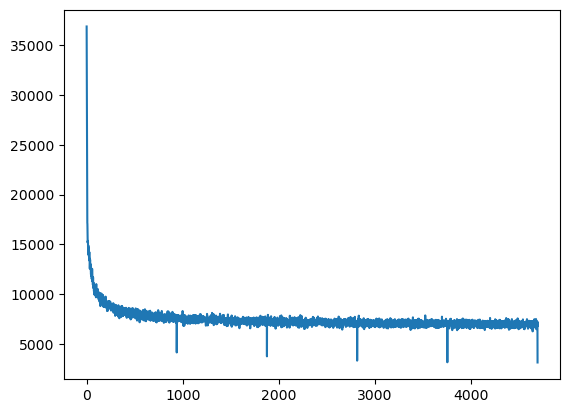

In [7]:
plot(losses)

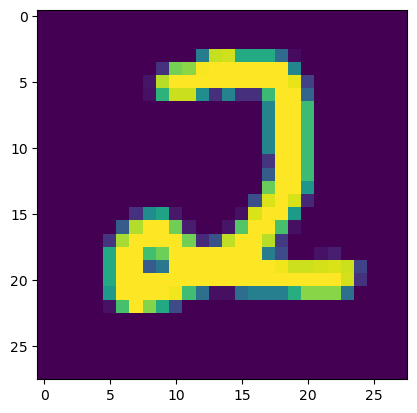

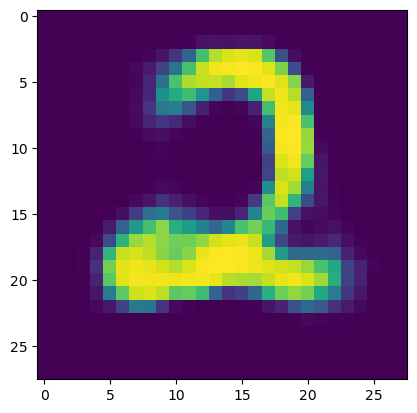

In [8]:
imshow(x[0].reshape(1,28,28).permute(1,2,0).cpu())
show()
imshow(x_hat[0].reshape(1,28,28).detach().permute(1,2,0).cpu())

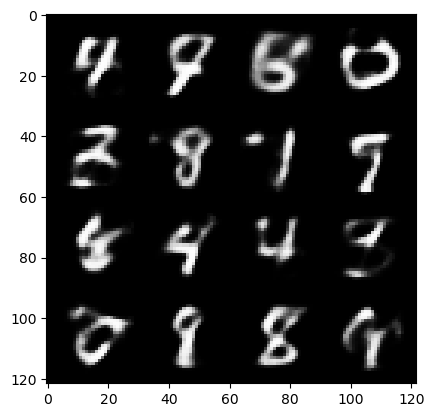

In [9]:
x = torch.randn(16,20).float().to(device)
model.eval()
with torch.no_grad():
    recon = model.decoder(x)
    recon = (recon +1)/2

grid = torchvision.utils.make_grid(recon.reshape(16,1,img_size,img_size), nrow = 4)
imshow(grid.cpu().permute(1,2,0))

In [10]:
loss_kl

tensor(762.2234, device='cuda:0', grad_fn=<NegBackward0>)

# VAE convolutionnal architecture

In [5]:
from models import VAE_3D
import yaml

with open('./parameters/VAE_MNIST.yaml', 'rb') as f:
    try:
        config = yaml.safe_load(f)
    except yaml.YAMLError as exc:
        print(exc)

model2d = VAE_3D(config, img_shape = (1,28,28), nb_classes=10)
model2d.to(device)


VAE_3D(
  (enc_convs): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
  )
  (mlp_mu): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=1024, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=2, bias=True)
      (1):

In [6]:
def loss_function(x, x_pred, mu, logvar, kl_weight):
    loss = F.binary_cross_entropy(x_pred, x, reduction = 'sum') 
    loss_kl = - 0.5 * torch.sum(torch.sum(1-mu**2 - logvar.exp() +logvar, dim = 1), dim = 0)
    loss += loss_kl
    return loss, loss_kl
    

In [7]:
lr = 0.001
kl_weight = 1
optimizer = torch.optim.AdamW(model2d.parameters(), lr = lr)
epochs = 5

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=1, verbose=True)


In [118]:
losses2d = []
losses_kl = []
model2d.train()
for _ in range(epochs):
    pbar = tqdm.tqdm(dataloader)
    losses_epoch = []
    for batch, labels in pbar: 
        optimizer.zero_grad()

        x = batch.float().to(device)
        x_hat, mu, logvar = model2d(x)

        loss, loss_kl = loss_function((x/2+.5),(x_hat/2+.5), mu, logvar, kl_weight=kl_weight)
        loss.backward()
        optimizer.step()
        
        losses_kl.append(loss_kl.item())
        losses_epoch.append(loss.item())

        pbar.set_description(f'Loss: %.3f' % loss.item())
    
    mean_loss = mean(losses_epoch)
    losses2d.extend(losses_epoch)
    scheduler.step(mean_loss)



Loss: 9644.210:  11%|█         | 103/938 [00:06<00:53, 15.65it/s] 


KeyboardInterrupt: 

In [119]:
loss_kl

tensor(371.6672, device='cuda:0', grad_fn=<MulBackward0>)

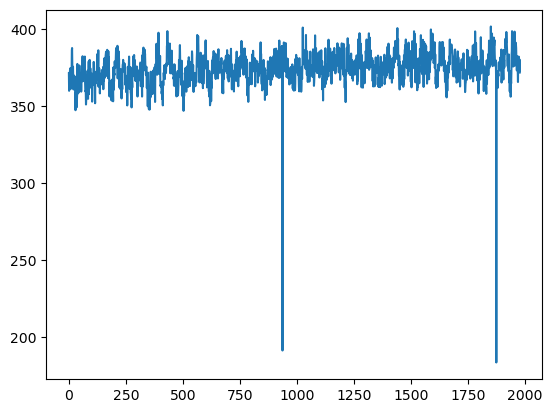

In [120]:
plot(losses_kl)

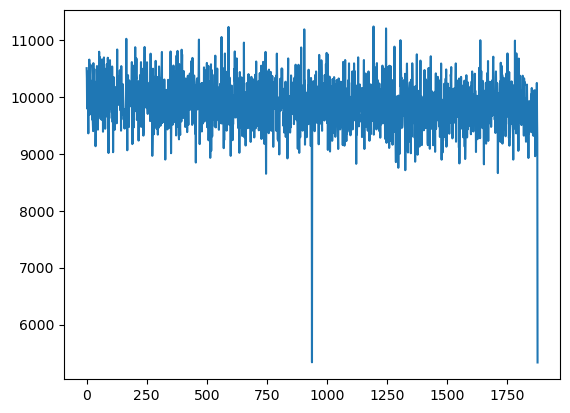

In [121]:
plot(losses2d)

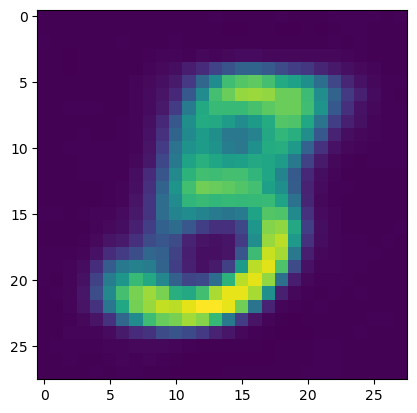

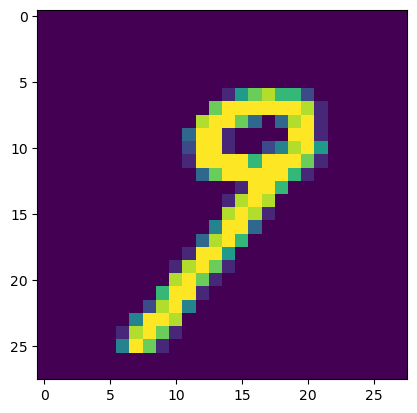

In [122]:
imshow((x_hat[20]/2+.5).detach().permute(1,2,0).cpu().numpy())
show()
imshow(x[20].detach().permute(1,2,0).cpu().numpy())

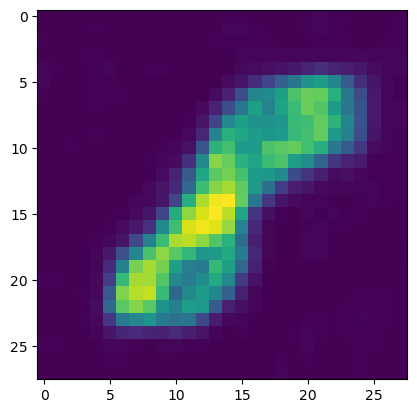

In [123]:
model2d.eval()
with torch.no_grad():
    if model2d.conditionnal:
        for l in range(10):
            gen_img = (model2d.sample(1).cpu()[0]+1)/2
            imshow(gen_img.permute(1,2,0))
            show()
    else:
        gen_img = (model2d.sample(1).cpu()[0]/2+.5)
        imshow(gen_img.permute(1,2,0))

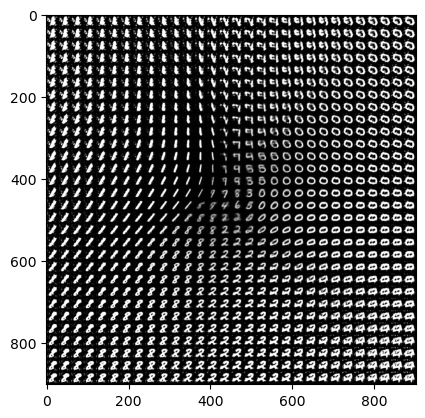

In [124]:
if model2d.latent_dim==2:
    grid = model2d.eval_manifold()

    if model2d.conditionnal:
        for g in grid:
            imshow(g.permute(1,2,0))
            show()
    else:
        imshow((grid).permute(1,2,0))

In [8]:
#torch.save(model2d.state_dict(), './working_VAE_3D_latent2.pth')
#model2d.load_state_dict(torch.load('./working_VAE_3D_latent2.pth'))

<All keys matched successfully>

In [28]:
test_dataset = torchvision.datasets.MNIST(root='.', download=True,train=False,
                     transform=transforms.Compose([
                     transforms.ToTensor(),
                     transforms.Normalize((0.5,), (0.5,))
                     ]))

# Dataloader
test_dataloader = DataLoader(test_dataset, batch_size=2000)

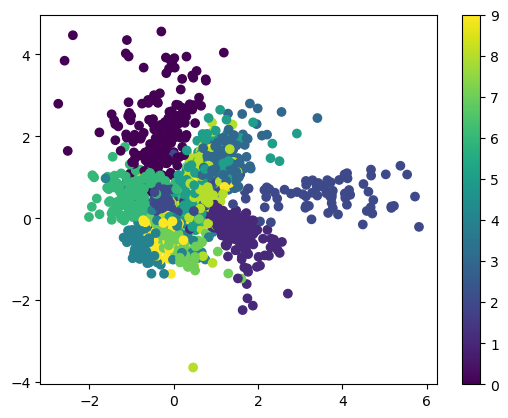

In [31]:
batch, label = next(iter(test_dataloader))
mu, logvar = model2d.encode(batch.to(device))
z = model2d.reparameterize(mu, logvar).cpu().detach()
scatter(z[:,0], z[:,1], c= list(label.numpy()), cmap = 'viridis')
colorbar()

# VAE COMPLEX

In [116]:
with open('./parameters/VAEcomplex_MNIST_params.yaml') as f:
    config_complex = yaml.safe_load(f)
from  models import VAE_complex
model = VAE_complex(config_complex['model'])
model.to(device)

VAE_complex(
  (init_conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (encoder_blocks): ModuleList(
    (0): VAE_Block(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (last_activatio

In [117]:
def loss_function(x, x_pred, mu, logvar, kl_weight):
    loss = F.binary_cross_entropy(x_pred, x, reduction = 'sum') 
    loss_kl = - 0.5 * torch.sum(torch.sum(1-mu**2 - logvar.exp() +logvar, dim = 1), dim = 0)
    loss += loss_kl
    return loss, loss_kl
    

In [118]:
lr = 0.001
kl_weight = 1
optimizer = torch.optim.AdamW(model.parameters(), lr = lr)
epochs = 20

In [119]:
losses2d = []
losses_kl = []
model.train()
for _ in range(epochs):
    pbar = tqdm.tqdm(dataloader)
    losses_epoch = []
    for batch, labels in pbar: 
        optimizer.zero_grad()

        x = batch.float().to(device)
        x_hat, mu, logvar = model(x)

        loss, loss_kl = loss_function((x/2+.5),(x_hat/2+.5), mu, logvar, kl_weight=kl_weight)
        loss.backward()
        optimizer.step()
        
        losses_kl.append(loss_kl.item())
        losses_epoch.append(loss.item())

        pbar.set_description(f'Loss: %.3f' % loss.item())
    
    mean_loss = mean(losses_epoch)
    losses2d.extend(losses_epoch)



Loss: 2497.093:  35%|███▍      | 324/938 [00:11<00:21, 28.46it/s]


KeyboardInterrupt: 

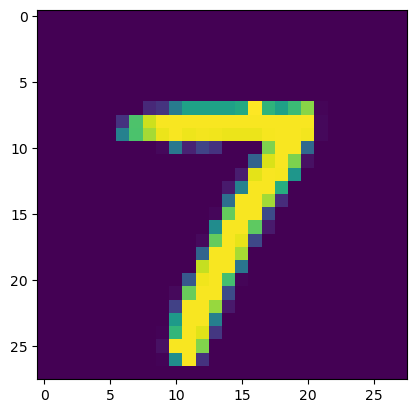

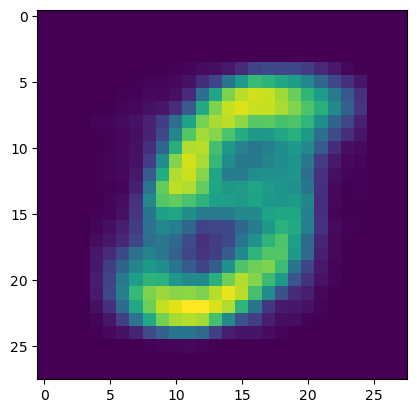

In [120]:
imshow(x.cpu()[0].permute(1,2,0))
show()
imshow((x_hat/2+.5).detach().cpu()[0].permute(1,2,0))

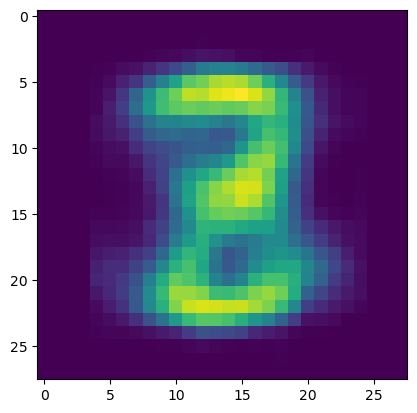

In [121]:
imshow(model.sample(1)[0].permute(1,2,0).cpu())

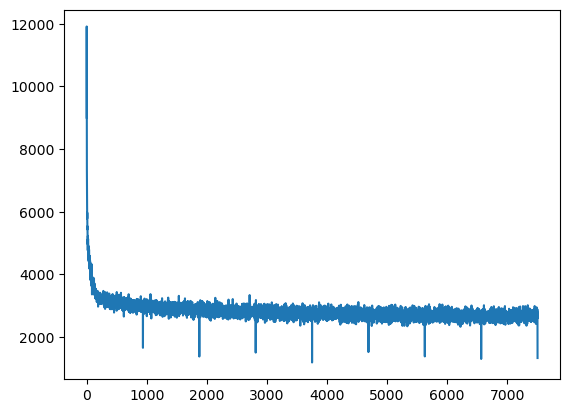

In [122]:
plot(losses2d)

In [123]:
nb_points = 900

import math

grid_side = int(math.sqrt(nb_points))
xs = torch.linspace(-10,10,grid_side)
ys = torch.linspace(-10,10,grid_side)

xs, ys = torch.meshgrid([xs,ys])
xs = xs.reshape(-1,1)
ys = ys.reshape(-1,1)
zs = torch.cat([xs,ys], dim = -1).to(device)

labels = torch.ones(nb_points,).to(device).long()
generated_img = model.decoder(zs)
generated_img = ((generated_img.cpu() + 1)/2)
grid = torchvision.utils.make_grid(generated_img, nrow = grid_side)


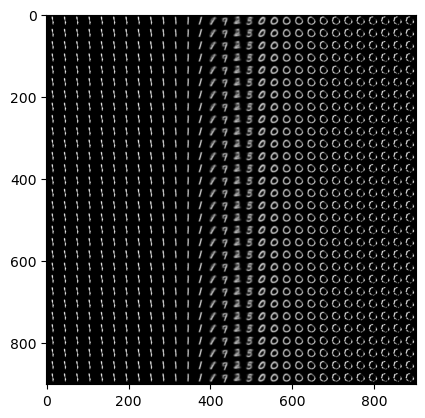

In [124]:
imshow(grid.cpu().permute(1,2,0))

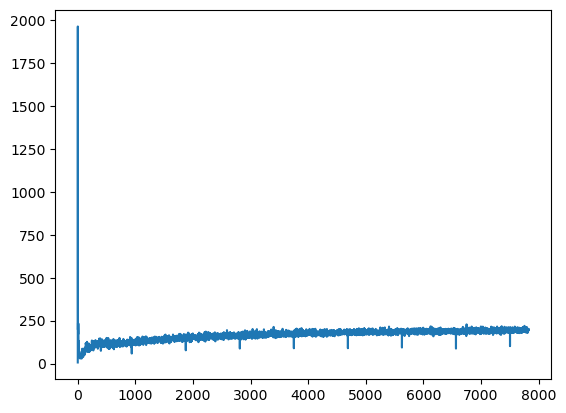

In [125]:
plot(losses_kl)